# masking technique name in subtitles

0it [00:00, ?it/s]

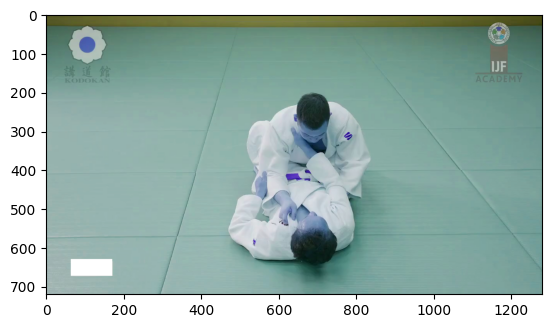

In [75]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def get_frames(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield frame


def mask_image(orig, threshold=0.9):
    img = orig.copy()
    img = img[630:700, :400]

    # lets binarize based on closeness to white
    t = 255 * threshold
    img = cv2.inRange(img, (t, t, t), (255, 255, 255), img)
    img = cv2.bitwise_not(img)

    # erode and dilate to get rid of the text
    kernel = np.ones((3, 3), np.uint8)
    img = cv2.erode(img, kernel, iterations=10)
    img = cv2.dilate(img, kernel, iterations=10)

    # now put the mask in a mask the size of the original image
    mask = np.zeros(orig.shape[:2], dtype=np.uint8)

    # now create a mask from the black pixels
    mask[:, :] = True
    mask[630:700, :400] = img != 0
    # print(mask, mask.dtype)
    # plt.imshow(mask)
    # plt.show()

    # apply the mask to white out the text over the original image
    masked = cv2.bitwise_and(orig, orig, mask=mask)
    # fill black with white
    masked[mask == 0] = 255
    return masked


videos = list(Path("../data/clips").glob("**/*.mp4"))
video = videos[0]
cap = cv2.VideoCapture(video.as_posix())
for frame in tqdm(get_frames(cap)):
    masked = mask_image(frame)
    break

plt.imshow(masked)
plt.show()

In [76]:
def mask_video(input, output, threshold=0.9):
    cap = cv2.VideoCapture(input.as_posix())
    for frame in get_frames(cap):
        break
    writer = cv2.VideoWriter(
        output.as_posix(),
        cv2.VideoWriter_fourcc(*"avc1"),
        25,
        (frame.shape[1], frame.shape[0]),
    )
    cap = cv2.VideoCapture(input.as_posix())
    for frame in get_frames(cap):
        writer.write(mask_image(frame, threshold))
    writer.release()


output = Path("../data/clips-masked")
output.mkdir(exist_ok=True, parents=True)
for video in tqdm(sorted(videos)):
    input = Path("../data/clips") / video.name
    output = Path("../data/clips-masked") / video.name.replace(".mp4", "_masked.mp4")
    threshold = 0.7 if "koshi-waza" in video.name else 0.9
    mask_video(input, output, threshold)

100%|██████████| 111/111 [02:47<00:00,  1.51s/it]
